<a href="https://colab.research.google.com/github/erados/Quantum-Computing/blob/main/qiskit_QAOA_%EA%B5%AC%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install qiskit # qiskit 설치

In [ ]:
import numpy as np  # 수학 라이브러리
import networkx as nx # 그래프 시각화 라이브러리

from qiskit import BasicAer # Aer 의 simulator 를 가져오기 위함.
from qiskit.optimization.applications.ising import max_cut  # max_cut 회로를 만들기 위한 class
from qiskit.optimization.applications.ising.common import random_graph, sample_most_likely  # 그래프를 만드는 함수, 가장 많이 나온 sample 를 반환하는 함수

In [ ]:
num_nodes = 6  # 노드 수
w = random_graph(num_nodes, edge_prob=0.5, weight_range=2, negative_weight=False, seed=48)  # 간선이 생길 확률 0.5, 가중치{0, 1} 로 랜덤 그래프 생성한다. (가중치는 max_cut.max_cut_value 에서 boolean 으로 변환됨)
print(w)  # 그래프의 가중치 행렬을 출력한다.

[[0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 1. 1.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1.]
 [0. 1. 1. 0. 1. 0.]]


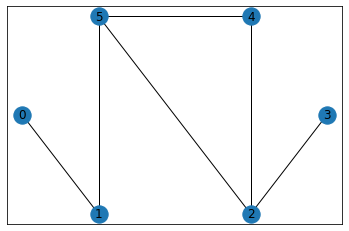

In [ ]:
G = nx.from_numpy_matrix(w) # 그래프 객체를 생성한다.
layout = nx.shell_layout(G) # Shell layout 을 사용한다.
nx.draw_networkx(G, layout) # 그래프를 그린다.

In [ ]:
def job_callback(job_id, job_status, queue_position, job): # QAOA 알고리즘을 실행할 때 job 의 status 를 알려주는 함수
    print(job_id)
    print(job_status)


def index_to_selection(i, num_nodes): # index 를 받아 2진수 np.array 로 변환하는 함수
    s = "{0:b}".format(i).rjust(num_nodes)
    x = np.array([1 if s[i]=='1' else 0 for i in reversed(range(num_nodes))])
    return x

    
def print_result(result): # QAOA 의 결과를 Value, String, 확률 순으로 모두 출력하는 함수
    selection = sample_most_likely(result.eigenstate)
    print(selection)
    value = max_cut.max_cut_value(selection, w)
    print('Optimal: selection {}, value {:.4f}'.format(selection, value))

    cnts = sum(result.eigenstate.values())
    probabilities = [i / cnts for i in result.eigenstate.values()]
    strings = [i for i in result.eigenstate ]
    dic = dict(zip(probabilities, strings))
    i_sorted = {k: v for k, v in sorted(dic.items(), key=lambda item: item[0], reverse=True)}
    print('\n----------------- Full result ---------------------')
    print('selection\tvalue\t\tprobability')
    print('---------------------------------------------------')
    for k in i_sorted:
        i_sorted[k]
        print('%10s\t%.4f\t\t%.4f' %(i_sorted[k], max_cut.max_cut_value(np.array([int(i) for i in i_sorted[k]]), w), k))


def brute_force():  # 모든 경우의 수에 대해 max_cut.max_cut_value 을 구하여 MaxCut String/Value 를 구하는 함수
    def bitfield(n, L): # L bits 로 만들 수 있는 string 들에서, n 번째 bit string 을 구하는 함수
        result = np.binary_repr(n, L) # n 을 2진수로 반환한다.
        return [int(digit) for digit in result] # 2진수를 int 리스트로 변환한다. 
    L = num_nodes # 노드 수
    max = 2**L # 2진수의 상한
    maximum_v = 0 # MaxCut value 변수
    string = [0 for i in range(num_nodes)] # string 을 binary '0' 으로 초기화
    for i in range(max): # 모든 경우에 수에 대한 반복문 시작
        cur = bitfield(i, L) # bit string 변수
        cur_v = max_cut.max_cut_value(np.array(cur), w) # 해당 bit string 에 대한 MaxCut value 계산
        
        if maximum_v < cur_v: # 최댓값이 갱신되면
            maximum_v = cur_v # MaxCut value 을 갱신
            string = cur  # MaxCut string 을 갱신

    return maximum_v , string # MaxCut String/Value 를 반환

sol = brute_force() # brute-force 를 사용한 MaxCut 의 해를 저장
print(f'Objective value computed by the brute-force method is {sol}') # # brute-force 를 사용한 MaxCut 의 해를 출력


Objective value computed by the brute-force method is (5.0, [0, 1, 0, 1, 1, 0])


In [ ]:
from qiskit import IBMQ
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import QAOA
from qiskit.aqua.components.optimizers import NELDER_MEAD, COBYLA, SPSA, CG
from qiskit.providers.ibmq import least_busy

# IBMQ.save_account('b79e58b4c2d0407d6dbea211073fa0e77fa1a6f23d064e824fa8a2086360f560932ffaa034f37896d68720582f4cbf85560ba4e13a0870bfb60fce30bd2b3685', overwrite=True) # 양자 프로세서를 사용하기위한 토큰을 저장
# provider = IBMQ.load_account() # 저장한 토큰으로 IBM Quantum-experience 에 접속
# matched_devices = provider.backends(filters=lambda x: x.configuration().n_qubits >= num_nodes and not x.configuration().simulator) # 그래프의 노드 수 이상의 큐빗을 가지고 있는 Backend Device 를 선택
# backend = least_busy(matched_devices) # 그 중에서 가장 queue 가 짧은 device 를 backend 로 선택
# print(backend) # 선택된 backend 이름을 출력

backend = BasicAer.get_backend('statevector_simulator') # 양자 시뮬레이터를 backend 로 선택

# optimizer = NELDER_MEAD() # Nelder-Mead 알고리즘으로 parameter 를 최적화
optimizer = COBYLA(maxiter=5) # COBYLA 알고리즘으로 parameter 를 'maxiter' 번 최적화

quantum_instance = QuantumInstance(backend=backend, job_callback=job_callback, shots=2048) # backend 와 job 콜백함수와 샷 횟수를 지정

qubit_op = max_cut.get_operator(w)[0]  # 가중치 행렬에서 해밀토니안을 반환
qaoa = QAOA(qubit_op, optimizer, quantum_instance=quantum_instance, p = 1) # QAOA 객체를 생성, depth = p

result = qaoa.run() # QAOA 를 실행

x = sample_most_likely(result.eigenstate) # 가장 많이 나온 Bit string 을 선택

print(f'Objective string and value computed by QAOA is {x}, {max_cut.max_cut_value(x, w)}')

Objective string and value computed by QAOA is [0. 1. 1. 0. 0. 0.], 5.0


In [ ]:
print_result(result) # 모든 결과를 출력

[1 0 0 0 1]
Optimal: selection [1 0 0 0 1], value 3.0000

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
     10001	3.0000		0.1094
     01101	2.0000		0.1074
     01110	3.0000		0.0942
     10010	2.0000		0.0869
     10011	2.0000		0.0586
     01111	1.0000		0.0527
     00001	2.0000		0.0376
     00010	1.0000		0.0361
     00101	1.0000		0.0322
     11110	2.0000		0.0308
     11101	1.0000		0.0288
     11001	2.0000		0.0273
     01100	2.0000		0.0254
     10101	2.0000		0.0225
     00110	2.0000		0.0220
     11011	1.0000		0.0205
     10000	1.0000		0.0200
     10110	3.0000		0.0195
     01001	3.0000		0.0190
     11111	0.0000		0.0151
     01010	2.0000		0.0137
     00111	0.0000		0.0117
     11100	1.0000		0.0112
     00100	1.0000		0.0103
     01011	2.0000		0.0098
     10100	2.0000		0.0073
     00000	0.0000		0.0068
     11000	0.0000		0.0063
     01000	1.0000		0.0039
